# Imports and Setup

In [118]:
# Data handling and manipulation
import numpy as np
import pandas as pd
import polars as pl
from collections import Counter
from pathlib import Path

# Data preprocessing
from sklearn.preprocessing import OrdinalEncoder
from imblearn.over_sampling import SMOTE

# Model selection and evaluation
from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_curve, auc, roc_auc_score, recall_score, confusion_matrix

# Model implementation
import lightgbm as lgb

# Experiment tracking
import mlflow
import mlflow.lightgbm

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [119]:
class CONFIG:
    
    # Directories to competition data
    train_path = Path('./data/train-metadata.csv')
    test_path = Path('./data/test-metadata.csv')
    subm_path = Path('./data/sample_submission.csv')
    train_embed_path = Path('./data/image_features/isic2024_train_data_img_emb_classifier.parquet')
    test_embed_path = Path('./data/image_features/isic2024_test_data_img_emb_classifier.parquet')
    
    # Undersampling and Oversampling
    # Ratio of negative to positive samples
    ## In original training data distribution is:
                                                ## target
                                                ## 0    400666
                                                ## 1       393
    NEG_RATIO = 50 #50
    SMOTE = True
    SMOTE_RATIO = 0.1
    K_NEIGHBORS = 2
    
    # Features to use
    DOMAIN_FEATURES = True # Initial features
    GROUP_FEATURES = True
    IMAGE_FEATURES = False # Add isic_id column if True
    
    # Early stopping rounds
    EARLY_STOP = 30
    
    # Number of KFold splits
    N_SPLITS = 5 #6
    
    # Testing encode or not cat_cols
    ENCODE_CAT = True
    
    # LightGBM parameters
    simple_params = {
    "objective": "binary",
    "verbosity": -1,
    "boosting_type": "gbdt",
    "n_estimators": 200,
    'learning_rate': 0.05,    
    'lambda_l1': 0.0005, 
    'lambda_l2': 8, 
    'num_leaves': 130, 
    'feature_fraction': 0.5, 
    'bagging_fraction': 1, 
    'bagging_freq': 6,
    'min_child_samples': 60
    }

# Data Preprocessing

In [120]:
class ISIC2024_Preprocessing:
    
    def __init__(self):
        pass
    
    def filter_data(self, path):
        
        # Read dataset as polars DataFrame
        df = pl.read_csv(path, low_memory=True)
            
        # Drop redundant columns 
        for col in [
                    'isic_id', # Redundant for loading train data
                    'image_type', # Only one unique value on train metadata
                    'tbp_lv_location_simple', # Similar information to 'tbp_lv_location'
                    'copyright_license', # Redundant information for lesion classification
                    
                    # Included only on train metadata
                    'lesion_id',
                    'iddx_full',
                    'iddx_1',
                    'iddx_2',
                    'iddx_3',
                    'iddx_4',
                    'iddx_5',
                    'mel_mitotic_index',
                    'mel_thick_mm',
                    'tbp_lv_dnn_lesion_confidence']:
            
            if col in df.columns:
                df = df.drop(col)            

        return df 
    
    def set_datatypes(self, df):
        
        # Handle NA values in age approximation column
        if ('age_approx' in df.columns) and df.select(pl.col('age_approx').str.contains('NA').any()).item():
            
            # Replace the value with -1
            df = df.with_columns(pl.when(pl.col('age_approx') == 'NA').then(-1).otherwise(pl.col('age_approx'))
                   .alias('age_approx'))
            
        # Define numeric columns (int)
        for col in ['target',
                    'age_approx',
                    'tbp_lv_symm_2axis_angle']:
            
            # Set dtype for numeric columns (int)
            if col in df.columns:
                df = df.with_columns(pl.col(col).cast(pl.Int16))
                        
        # Define numeric columns (float)
        for col in ['clin_size_long_diam_mm', 
                    'tbp_lv_A', 
                    'tbp_lv_Aext', 
                    'tbp_lv_B', 
                    'tbp_lv_Bext', 
                    'tbp_lv_C', 
                    'tbp_lv_Cext',
                    'tbp_lv_H', 
                    'tbp_lv_Hext',
                    'tbp_lv_L', 
                    'tbp_lv_Lext',
                    'tbp_lv_areaMM2', 
                    'tbp_lv_area_perim_ratio',
                    'tbp_lv_color_std_mean',
                    'tbp_lv_deltaA', 
                    'tbp_lv_deltaB',
                    'tbp_lv_deltaL', 
                    'tbp_lv_deltaLB',
                    'tbp_lv_deltaLBnorm',
                    'tbp_lv_eccentricity', 
                    'tbp_lv_minorAxisMM',
                    'tbp_lv_nevi_confidence',
                    'tbp_lv_norm_border',
                    'tbp_lv_norm_color',
                    'tbp_lv_perimeterMM',
                    'tbp_lv_radial_color_std_max',
                    'tbp_lv_stdL',
                    'tbp_lv_stdLExt',
                    'tbp_lv_symm_2axis',
                    'tbp_lv_x',
                    'tbp_lv_y',
                    'tbp_lv_z']: 
            
            # Set dtype for numeric columns (float)
            if col in df.columns:
                df = df.with_columns(pl.col(col).cast(pl.Float32))
                
        # Define categorical columns
        for col in ['sex', 
                    'anatom_site_general', 
                    'tbp_tile_type', 
                    'tbp_lv_location',
                    'attribution']:
            
            # Set dtype for categorical columns
            if col in df.columns:
                df = df.with_columns(pl.col(col).cast(pl.Categorical))
                                            
        return df
    
    def initial_preprocessing(self, df):
        
        # Filter data
        df = self.filter_data(df)
        
        # Set datatypes
        df = self.set_datatypes(df)
        
        return df

In [121]:
pp = ISIC2024_Preprocessing()
pl_train = pp.initial_preprocessing(CONFIG.train_path)
pl_test = pp.initial_preprocessing(CONFIG.test_path)

# Feature Engineering

In [122]:
class ISIC2024_FeatureEngineering:
    
    def __init__(self):
        pass
    
    def feature_engineering(self, df):
        
        # Taken from: https://www.kaggle.com/code/vyacheslavbolotin/ensemble-lgbm-cat-with-new-features
        
        df =  df.with_columns([
            
            #New num cols   
            pl.col("tbp_lv_minorAxisMM").truediv(pl.col("clin_size_long_diam_mm")).alias("lesion_size_ratio"),
            pl.col("tbp_lv_areaMM2").truediv(pl.col("tbp_lv_perimeterMM").pow(2)).alias("lesion_shape_index"),
            pl.col("tbp_lv_H").sub(pl.col("tbp_lv_Hext")).abs().alias("hue_contrast"),
            pl.col("tbp_lv_L").sub(pl.col("tbp_lv_Lext")).abs().alias("luminance_contrast"),
            pl.col("tbp_lv_deltaA").pow(2).add(pl.col("tbp_lv_deltaB").pow(2)).add(pl.col("tbp_lv_deltaL").pow(2)).sqrt().alias("lesion_color_difference"),
            pl.col("tbp_lv_norm_border").add(pl.col("tbp_lv_symm_2axis")).alias("border_complexity"),
            pl.col("tbp_lv_x").pow(2).add(pl.col("tbp_lv_y").pow(2)).add(pl.col("tbp_lv_z").pow(2)).sqrt().alias("3d_position_distance"),
            pl.col("tbp_lv_perimeterMM").truediv(pl.col("tbp_lv_areaMM2")).alias("perimeter_to_area_ratio"),
            pl.col("tbp_lv_deltaLBnorm").add(pl.col("tbp_lv_norm_color")).alias("lesion_visibility_score"),
            pl.col("tbp_lv_symm_2axis").mul(pl.col("tbp_lv_norm_border")).alias("symmetry_border_consistency"),
            pl.col("tbp_lv_stdL").truediv(pl.col("tbp_lv_Lext")).alias("color_consistency"),
            pl.col("clin_size_long_diam_mm").mul(pl.col("age_approx")).alias("size_age_interaction"),
            pl.col("tbp_lv_H").mul(pl.col("tbp_lv_color_std_mean")).alias("hue_color_std_interaction"),
            pl.col("tbp_lv_norm_border").add(pl.col("tbp_lv_norm_color")).add(pl.col("tbp_lv_eccentricity")).truediv(3).alias("lesion_severity_index"),
            pl.col("tbp_lv_deltaA").add(pl.col("tbp_lv_deltaB")).add(pl.col("tbp_lv_deltaL")).add(pl.col("tbp_lv_deltaLBnorm")).alias("color_contrast_index"),
            pl.col("tbp_lv_areaMM2").add(1).log().alias("log_lesion_area"),
            pl.col("clin_size_long_diam_mm").truediv(pl.col("age_approx")).alias("normalized_lesion_size"),
            pl.col("tbp_lv_H").add(pl.col("tbp_lv_Hext")).truediv(2).alias("mean_hue_difference"),
            pl.col("tbp_lv_deltaA").pow(2).add(pl.col("tbp_lv_deltaB").pow(2)).add(pl.col("tbp_lv_deltaL").pow(2)).truediv(3).sqrt().alias("std_dev_contrast"),
            pl.col("tbp_lv_color_std_mean").add(pl.col("tbp_lv_area_perim_ratio")).add(pl.col("tbp_lv_symm_2axis")).truediv(3).alias("color_shape_composite_index"),
            pl.col("tbp_lv_deltaA").add(pl.col("tbp_lv_deltaB")).add(pl.col("tbp_lv_deltaL")).truediv(3).alias("overall_color_difference"),
            pl.col("tbp_lv_symm_2axis").mul(pl.col("tbp_lv_perimeterMM")).alias("symmetry_perimeter_interaction"),
            pl.col("tbp_lv_area_perim_ratio").add(pl.col("tbp_lv_eccentricity")).add(pl.col("tbp_lv_norm_color")).add(pl.col("tbp_lv_symm_2axis")).truediv(4).alias("comprehensive_lesion_index")])
        
        # This one generates NaN and inf values
        df = df.with_columns(
            pl.col("tbp_lv_color_std_mean").truediv(pl.col("tbp_lv_radial_color_std_max")).alias('color_uniformity')
        )

        # Replace NaN and Inf values with 0
        df = df.with_columns(
            pl.when(pl.col('color_uniformity').is_nan() | (pl.col('color_uniformity').is_infinite())).then(0).otherwise(pl.col('color_uniformity')).alias('color_uniformity')
        )
        
        df = df.with_columns([
            
            pl.col("anatom_site_general").add("_").add(pl.col("tbp_lv_location")).cast(pl.Categorical).alias("combined_anatomical_site"),
            pl.col("border_complexity").add(pl.col("lesion_shape_index")).alias("shape_complexity_index"),
            pl.arctan2(pl.col("tbp_lv_y"), pl.col("tbp_lv_x")).alias("3d_lesion_orientation")
        ])
        
        # Taken from: https://www.kaggle.com/code/dschettler8845/isic-detect-skin-cancer-let-s-learn-together
        
        df =  df.with_columns([    
                            
            #New num cols
            pl.col("tbp_lv_color_std_mean").truediv(pl.col("tbp_lv_stdLExt")).alias("color_variance_ratio"),
            pl.col("tbp_lv_norm_border").mul(pl.col("tbp_lv_norm_color")).alias("border_color_interaction"),
            pl.col("clin_size_long_diam_mm").truediv(pl.col("tbp_lv_deltaLBnorm")).alias("size_color_contrast_ratio"),
            pl.col("tbp_lv_nevi_confidence").truediv(pl.col("age_approx")).alias("age_normalized_nevi_confidence"),
            pl.col("tbp_lv_radial_color_std_max").mul(pl.col("tbp_lv_symm_2axis")).alias("color_asymmetry_index"),
            pl.col("tbp_lv_areaMM2").mul(pl.col("tbp_lv_x").pow(2).add(pl.col("tbp_lv_y").pow(2)).add(pl.col("tbp_lv_z").pow(2)).sqrt()).alias("3d_volume_approximation"),
            pl.col("tbp_lv_L").sub(pl.col("tbp_lv_Lext")).abs().add(pl.col("tbp_lv_A").sub(pl.col("tbp_lv_Aext")).abs()).add(pl.col("tbp_lv_B").sub(pl.col("tbp_lv_Bext")).abs()).alias("color_range"),
            pl.col("tbp_lv_eccentricity").mul(pl.col("tbp_lv_color_std_mean")).alias("shape_color_consistency"),
            pl.col("tbp_lv_perimeterMM").truediv(pl.lit(2 * np.pi).mul(pl.col("tbp_lv_areaMM2").truediv(np.pi).sqrt())).alias("border_length_ratio"),
            pl.col("age_approx").mul(pl.col("clin_size_long_diam_mm")).mul(pl.col("tbp_lv_symm_2axis")).alias("age_size_symmetry_index")
        ])
        
        return df

    def grouped_feature_engineering(self, df):
            
            # Taken from: https://www.kaggle.com/code/andreasbis/isic-2024-cnn-predictions-as-features
            
            df = df.with_columns([
                
                # Ratio of A* to the product of A*ext and age minimum A*
                pl.col('tbp_lv_A').truediv(pl.col('tbp_lv_Aext').mul(pl.col('tbp_lv_A').min()))
                .over('age_approx')
                .cast(pl.Float32).alias('tbp_lv_ratio_A'),
                
                # Ratio of B* to the product of B*ext and age minimum B*
                pl.col('tbp_lv_B').truediv(pl.col('tbp_lv_Bext').mul(pl.col('tbp_lv_B').min()))
                .over('age_approx')
                .cast(pl.Float32).alias('tbp_lv_ratio_B'),
                
                # Ratio of C* to the product of C*ext and age minimum C*
                pl.col('tbp_lv_C').truediv(pl.col('tbp_lv_Cext').mul(pl.col('tbp_lv_C').min()))
                .over('age_approx')
                .cast(pl.Float32).alias('tbp_lv_ratio_C'),
                
                # Ratio of H* to the product of H*ext and age minimum H*
                pl.col('tbp_lv_H').truediv(pl.col('tbp_lv_Hext').mul(pl.col('tbp_lv_H').min()))
                .over('age_approx')
                .cast(pl.Float32).alias('tbp_lv_ratio_H'),
                
                # Ratio of L* to the product of L*ext and age minimum L*
                pl.col('tbp_lv_L').truediv(pl.col('tbp_lv_Lext').mul(pl.col('tbp_lv_L').min()))
                .over('age_approx')
                .cast(pl.Float32).alias('tbp_lv_ratio_L'),
                
            ])
            
            df = df.with_columns([
                
                # Contrast between A* and A*ext
                pl.col('tbp_lv_A').sub(pl.col('tbp_lv_Aext'))
                .cast(pl.Float32).alias('tbp_lv_contrast_A'),
                
                # Contrast between B* and B*ext
                pl.col('tbp_lv_B').sub(pl.col('tbp_lv_Bext'))
                .cast(pl.Float32).alias('tbp_lv_contrast_B'),
                
                # Contrast between C* and C*ext
                pl.col('tbp_lv_C').sub(pl.col('tbp_lv_Cext'))
                .cast(pl.Float32).alias('tbp_lv_contrast_C'),
                
                # Contrast between H* and H*ext                   # Redundant with hue_contrast
                pl.col('tbp_lv_H').sub(pl.col('tbp_lv_Hext'))
                .cast(pl.Float32).alias('tbp_lv_contrast_H'),        
                
                # Contrast between L* and L*ext                   # Redundant with luminance_contrast
                pl.col('tbp_lv_L').sub(pl.col('tbp_lv_Lext'))
                .cast(pl.Float32).alias('tbp_lv_contrast_L'), 
                
            ])
            
            df = df.with_columns([     
                
                # Ratio of tbp_lv_ratio_A to patient average
                pl.col('tbp_lv_ratio_A').truediv(pl.col('tbp_lv_ratio_A').mean())
                .over('patient_id')
                .cast(pl.Float32).alias('tbp_lv_patient_ratio_A'),
                
                # Ratio of tbp_lv_ratio_B to patient average
                pl.col('tbp_lv_ratio_B').truediv(pl.col('tbp_lv_ratio_B').mean())
                .over('patient_id')
                .cast(pl.Float32).alias('tbp_lv_patient_ratio_B'),
                
                # Ratio of tbp_lv_ratio_C to patient average
                pl.col('tbp_lv_ratio_C').truediv(pl.col('tbp_lv_ratio_C').mean())
                .over('patient_id')
                .cast(pl.Float32).alias('tbp_lv_patient_ratio_C'),
                
                # Ratio of tbp_lv_ratio_H to patient average
                pl.col('tbp_lv_ratio_H').truediv(pl.col('tbp_lv_ratio_H').mean())
                .over('patient_id')
                .cast(pl.Float32).alias('tbp_lv_patient_ratio_H'),
                
                # Ratio of tbp_lv_ratio_L to patient average
                pl.col('tbp_lv_ratio_L').truediv(pl.col('tbp_lv_ratio_L').mean())
                .over('patient_id')
                .cast(pl.Float32).alias('tbp_lv_patient_ratio_L'),
                
            ])
            
            df = df.with_columns([     
                
                # Ratio of tbp_lv_contrast_A to patient average
                pl.col('tbp_lv_contrast_A').truediv(pl.col('tbp_lv_contrast_A').mean())
                .over('patient_id')
                .cast(pl.Float32).alias('tbp_lv_patient_contrast_A'),
                
                # Ratio of tbp_lv_contrast_B to patient average
                pl.col('tbp_lv_contrast_B').truediv(pl.col('tbp_lv_contrast_B').mean())
                .over('patient_id')
                .cast(pl.Float32).alias('tbp_lv_patient_contrast_B'),
                
                # Ratio of tbp_lv_contrast_C to patient average
                pl.col('tbp_lv_contrast_C').truediv(pl.col('tbp_lv_contrast_C').mean())
                .over('patient_id')
                .cast(pl.Float32).alias('tbp_lv_patient_contrast_C'),
                
                # Ratio of tbp_lv_contrast_H to patient average
                pl.col('tbp_lv_contrast_H').truediv(pl.col('tbp_lv_contrast_H').mean())
                .over('patient_id')
                .cast(pl.Float32).alias('tbp_lv_patient_contrast_H'),
                
                # Ratio of tbp_lv_contrast_L to patient average
                pl.col('tbp_lv_contrast_L').truediv(pl.col('tbp_lv_contrast_L').mean())
                .over('patient_id')
                .cast(pl.Float32).alias('tbp_lv_patient_contrast_L'),
                
            ])
            
            df = df.with_columns([     
                
                # Ratio of tbp_lv_ratio_A to age average
                pl.col('tbp_lv_ratio_A').truediv(pl.col('tbp_lv_ratio_A').mean())
                .over('age_approx')
                .cast(pl.Float32).alias('tbp_lv_age_ratio_A'),
                
                # Ratio of tbp_lv_ratio_B to age average
                pl.col('tbp_lv_ratio_B').truediv(pl.col('tbp_lv_ratio_B').mean())
                .over('age_approx')
                .cast(pl.Float32).alias('tbp_lv_age_ratio_B'),
                
                # Ratio of tbp_lv_ratio_C to age average
                pl.col('tbp_lv_ratio_C').truediv(pl.col('tbp_lv_ratio_C').mean())
                .over('age_approx')
                .cast(pl.Float32).alias('tbp_lv_age_ratio_C'),
                
                # Ratio of tbp_lv_ratio_H to age average
                pl.col('tbp_lv_ratio_H').truediv(pl.col('tbp_lv_ratio_H').mean())
                .over('age_approx')
                .cast(pl.Float32).alias('tbp_lv_age_ratio_H'),
                
                # Ratio of tbp_lv_ratio_L to age average
                pl.col('tbp_lv_ratio_L').truediv(pl.col('tbp_lv_ratio_L').mean())
                .over('age_approx')
                .cast(pl.Float32).alias('tbp_lv_age_ratio_L'),
                
            ])
            
            df = df.with_columns([     
                
                # Ratio of tbp_lv_contrast_A to age average
                pl.col('tbp_lv_contrast_A').truediv(pl.col('tbp_lv_contrast_A').mean())
                .over('age_approx')
                .cast(pl.Float32).alias('tbp_lv_age_contrast_A'),
                
                # Ratio of tbp_lv_contrast_B to age average
                pl.col('tbp_lv_contrast_B').truediv(pl.col('tbp_lv_contrast_B').mean())
                .over('age_approx')
                .cast(pl.Float32).alias('tbp_lv_age_contrast_B'),
                
                # Ratio of tbp_lv_contrast_C to age average
                pl.col('tbp_lv_contrast_C').truediv(pl.col('tbp_lv_contrast_C').mean())
                .over('age_approx')
                .cast(pl.Float32).alias('tbp_lv_age_contrast_C'),
                
                # Ratio of tbp_lv_contrast_H to age average
                pl.col('tbp_lv_contrast_H').truediv(pl.col('tbp_lv_contrast_H').mean())
                .over('age_approx')
                .cast(pl.Float32).alias('tbp_lv_age_contrast_H'),
                
                # Ratio of tbp_lv_contrast_L to age average
                pl.col('tbp_lv_contrast_L').truediv(pl.col('tbp_lv_contrast_L').mean())
                .over('age_approx')
                .cast(pl.Float32).alias('tbp_lv_age_contrast_L'),
                
            ])
            
           
            return df
    
    def add_image_features(self, file_path):
        
        # Loads a file with full features
        img_df = pl.read_parquet(file_path)
        img_df = img_df.drop('isic_id')
        return img_df
    
    def extract_cat_cols(self, df):
        
        # Define a list of categorical columns
        cat_cols = []
        
        # Find categorical columns
        for col in df.columns:
            if df[col].dtype == pl.Categorical:
                cat_cols.append(col)
                
        return cat_cols
  
    def downsample_data_pl(self, df: pl.DataFrame, neg_ratio: float = None, is_train: bool = True) -> pl.DataFrame:
        
        if is_train:
            # Extract the counts of positive and negative cases
            p_cases = df.filter(pl.col('target') == 1)
            n_cases = df.filter(pl.col('target') == 0)

            # If neg_ratio is None use all negative samples
            if neg_ratio is not None:
                N = int(p_cases.height * neg_ratio)
                n_cases = n_cases.sample(n=N, seed=23)
            
            # Concatenar los casos negativos y positivos
            df = pl.concat([n_cases, p_cases])
            
        return df

    def process_data(self, df, neg_ratio=None, is_train=True, img_fea_path=None):

        
        if CONFIG.DOMAIN_FEATURES:
            # Create initial features
            df = self.feature_engineering(df)

        # Check if group-specific features should be added
        if CONFIG.GROUP_FEATURES:
            # Create age and patient group features
            df = self.grouped_feature_engineering(df)

        # Check if image features should be added
        if CONFIG.IMAGE_FEATURES:
            # Replace data with loaded image features (data is 1:20 downsampled already)
            df = self.add_image_features(img_fea_path)

        # Extract categorical columns
        cat_cols = self.extract_cat_cols(df)

        # Downsample data if image features are not used
        if not CONFIG.IMAGE_FEATURES:
            df = self.downsample_data_pl(df, neg_ratio, is_train)

        # Convert to pandas DataFrame
        df = df.to_pandas()

        return df, cat_cols


In [123]:
fe = ISIC2024_FeatureEngineering()
train_data, cat_cols = fe.process_data(pl_train.clone(), CONFIG.NEG_RATIO, img_fea_path=CONFIG.train_embed_path)
test_data, _ = fe.process_data(pl_test.clone(), is_train=False, img_fea_path=CONFIG.test_embed_path)

def print_df_info(df):
    # Count the number of columns by data type
    int_cols = df.select_dtypes(include=['int']).shape[1]
    float_cols = df.select_dtypes(include=['float']).shape[1]
    cat_cols = df.select_dtypes(include=['category']).shape[1]
    obj_cols = df.select_dtypes(include=['object']).shape[1]

    # Calculate the total number of nulls in the DataFrame
    total_nulls = df.isnull().sum().sum()
    shape = df.shape
    
    # Print the results
    print(f"Shape: {shape}")
    print(f"Number of integer columns: {int_cols}")
    print(f"Number of float columns: {float_cols}")
    print(f"Number of categorical columns: {cat_cols}")
    print(f"Number of object columns: {obj_cols}")
    print(f"Total number of nulls in the DataFrame: {total_nulls}")


print("\nFINAL TRAIN INFORMATION:")
print_df_info(train_data)
print("\nFINAL TEST INFORMATION:")
print_df_info(test_data)

# Final categorical columns
print(f"\nFinal categorical columns: \n{cat_cols}")


FINAL TRAIN INFORMATION:
Shape: (20043, 108)
Number of integer columns: 0
Number of float columns: 98
Number of categorical columns: 6
Number of object columns: 1
Total number of nulls in the DataFrame: 0

FINAL TEST INFORMATION:
Shape: (3010, 108)
Number of integer columns: 0
Number of float columns: 98
Number of categorical columns: 6
Number of object columns: 1
Total number of nulls in the DataFrame: 144

Final categorical columns: 
['sex', 'anatom_site_general', 'tbp_tile_type', 'tbp_lv_location', 'attribution', 'combined_anatomical_site']


# Encode categorical for SMOTE

In [124]:
if CONFIG.ENCODE_CAT:
    
    category_encoder = OrdinalEncoder(
        categories='auto', dtype=np.int16, 
        handle_unknown='use_encoded_value', 
        unknown_value=-2, encoded_missing_value=-1
    )

    train_data_encoded = category_encoder.fit_transform(train_data[cat_cols])
    # Assign the transformed categories back to the DataFrame
    for c, cat_col in enumerate(cat_cols):
        train_data[cat_col] = train_data_encoded[:, c]
        
    test_data_encoded = category_encoder.transform(test_data[cat_cols])
    # Assign the transformed categories back to the DataFrame
    for c, cat_col in enumerate(cat_cols):
        test_data[cat_col] = test_data_encoded[:, c]

# Competition Metric

In [125]:
def comp_score(solution: pd.DataFrame, submission: pd.DataFrame, row_id_column_name: str, min_tpr: float=0.80):
    v_gt = abs(np.asarray(solution.values)-1)
    v_pred = np.array([1.0 - x for x in submission.values])
    max_fpr = abs(1-min_tpr)
    partial_auc_scaled = roc_auc_score(v_gt, v_pred, max_fpr=max_fpr)
    # change scale from [0.5, 1.0] to [0.5 * max_fpr**2, max_fpr]
    # https://math.stackexchange.com/questions/914823/shift-numbers-into-a-different-range
    partial_auc = 0.5 * max_fpr**2 + (max_fpr - 0.5 * max_fpr**2) / (1.0 - 0.5) * (partial_auc_scaled - 0.5)
    return partial_auc

def recall_metric(y_true: np.ndarray, y_pred: np.ndarray, threshold: float=0.5) -> float:
    """
    Compute the recall metric.

    Args:
        y_true (np.ndarray): Ground truth binary labels (0s and 1s).
        y_pred (np.ndarray): Predicted probabilities.
        threshold (float): Threshold to convert probabilities to binary predictions.

    Returns:
        float: The recall score.
    """
    # Convert probabilities to binary predictions using the specified threshold
    y_pred_binary = (y_pred >= threshold).astype(int)
    
    # Compute recall score
    recall = recall_score(y_true, y_pred_binary)
    return recall

def plot_cm(y_true: np.ndarray, y_pred: np.ndarray, threshold: float=0.5):
    # Apply threshold to get binary predictions
    y_pred_binary = (y_pred >= threshold).astype(int)
    
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred_binary)
    
    # Get unique labels
    labels = sorted(np.unique(y_true))
    
    # Create the heatmap
    fig, ax = plt.subplots(figsize=(8, 8))
    sns.heatmap(cm,
                ax=ax, 
                annot=True, 
                fmt='d', 
                cmap='RdYlBu', 
                xticklabels=labels, 
                yticklabels=labels,
                cbar=True,
                square=True,
                annot_kws={"size": 16})
    
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()
    plt.close(fig)
    return fig

# LGBM Model Train

In [126]:
def smote_oversample(X, y, sampling_strategy=CONFIG.SMOTE_RATIO, k_neighbors=CONFIG.K_NEIGHBORS, random_state=23):
     
    smote = SMOTE(sampling_strategy=sampling_strategy, k_neighbors=k_neighbors, random_state=random_state)
    X_resampled, y_resampled = smote.fit_resample(X, y)
    
    return X_resampled, y_resampled

In [127]:
gkf = GroupKFold(n_splits=CONFIG.N_SPLITS)

train_data.reset_index(drop=True, inplace=True)

X = train_data.drop(["target", "patient_id"], axis=1)
y = train_data["target"]
groups = train_data["patient_id"]

# Initialize lists to store scores and models
lgb_scores = []
lgb_models = []

# Store X_valid and y_valid for each fold
full_X_valid = pd.DataFrame()
full_y_valids = []

# Perform cross-validation
for fold, (train_index, valid_index) in enumerate(gkf.split(X, y, groups)):

    # Split the data into training and validation sets for the current fold
    X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    
    # SMOTE
    if CONFIG.SMOTE:
        X_train_resampled, y_train_resampled = smote_oversample(X_train, y_train)
    
    # Create LightGBM datasets
        train_dataset = lgb.Dataset(X_train_resampled, label=y_train_resampled, categorical_feature=cat_cols)
    
    elif not CONFIG.SMOTE:
        train_dataset = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_cols)
    
    valid_dataset = lgb.Dataset(X_valid, label=y_valid, categorical_feature=cat_cols, reference=train_dataset)

    # Train the model
    model = lgb.train(CONFIG.simple_params, 
                        train_dataset,
                        valid_sets=[valid_dataset], 
                        callbacks=[lgb.early_stopping(CONFIG.EARLY_STOP, verbose=0)
                        ])
                        #             lgb.log_evaluation(0)]
                        
    # Make predictions
    preds = model.predict(X_valid)
    
    # Calculate score
    score = comp_score(y_valid, pd.DataFrame(preds, columns=["prediction"]), "")
    recall = recall_metric(y_valid, preds)
    print(f"fold: {fold} - Partial AUC Score: {score:.5f} - Recall: {recall:.5f}")
    
    lgb_scores.append(score)
    lgb_models.append(model)
    
# Calculate and log the average score in the parent run
avg_score = sum(lgb_scores) / len(lgb_scores)
print("-----------------------------------------")
print(f"CV Average Partial AUC Score: {avg_score:.5f} \n")

fold: 0 - Partial AUC Score: 0.17309 - Recall: 0.52857
fold: 1 - Partial AUC Score: 0.17394 - Recall: 0.45000
fold: 2 - Partial AUC Score: 0.16242 - Recall: 0.53521
fold: 3 - Partial AUC Score: 0.16035 - Recall: 0.40964
fold: 4 - Partial AUC Score: 0.15885 - Recall: 0.40580
-----------------------------------------
CV Average Partial AUC Score: 0.16573 



### Modified this to predict on full train for CM

pAUC of 5-fold mean predictions: 0.19982041968546244 

Recall of 5-fold mean predictions: 0.9338422391857506 



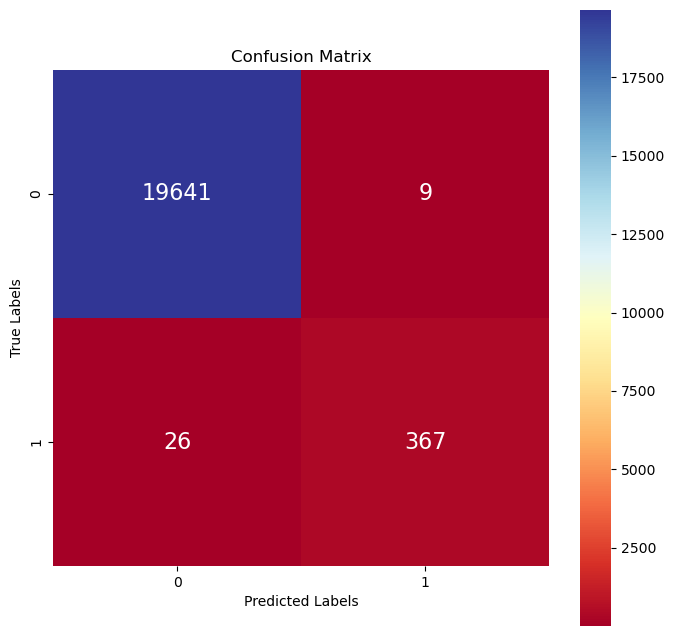

In [128]:
# Average the predictions of the LightGBM classifiers
mean_preds = np.mean([model.predict(X) for model in lgb_models], axis=0)
final_score = comp_score(y, pd.DataFrame(mean_preds, columns=['prediction']), '')
final_recall = recall_metric(y, mean_preds)

print(f"pAUC of 5-fold mean predictions: {final_score} \n")
print(f"Recall of 5-fold mean predictions: {final_recall} \n")
    
fig = plot_cm(y, mean_preds)

## mlflow setup, no SMOTE

In [129]:
""" mlflow.set_experiment("ISIC 2024 Local - Test Cat Encoding2")

with mlflow.start_run(run_name="Encoding integers"):
    
    # Log overall experiment parameters
    configuration = CONFIG.__dict__
    mlflow.log_param("Configuration", configuration)
    mlflow.log_param("Negative ratio", CONFIG.NEG_RATIO)
    mlflow.log_param("Image features", CONFIG.IMAGE_FEATURES)
    mlflow.log_param("Number of Features", train_data.shape[1])
    
    gkf = GroupKFold(n_splits=CONFIG.N_SPLITS)

    train_data.reset_index(drop=True, inplace=True)

    X = train_data.drop(["target", "patient_id"], axis=1)
    y = train_data["target"]
    groups = train_data["patient_id"]

    # Initialize lists to store scores and models
    lgb_scores = []
    lgb_models = []
    
    # Store X_valid and y_valid for each fold
    full_X_valid = pd.DataFrame()
    full_y_valids = []
    
    # Perform cross-validation
    for fold, (train_index, valid_index) in enumerate(gkf.split(X, y, groups)):
        
        # Split the data into training and validation sets for the current fold
        X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
        
        # Create LightGBM datasets
        train_dataset = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_cols)
        valid_dataset = lgb.Dataset(X_valid, label=y_valid, categorical_feature=cat_cols, reference=train_dataset)

        # Train the model
        model = lgb.train(CONFIG.simple_params, 
                            train_dataset,
                            valid_sets=[valid_dataset], 
                            callbacks=[lgb.early_stopping(CONFIG.EARLY_STOP, verbose=0)
                            ])
                            #             lgb.log_evaluation(0)]
                            
        # Make predictions
        preds = model.predict(X_valid)
        
        # Calculate score
        score = comp_score(y_valid, pd.DataFrame(preds, columns=["prediction"]), "")
        recall = recall_metric(y_valid, preds)
        print(f"fold: {fold} - Partial AUC Score: {score:.5f} - Recall: {recall:.5f}")
        
        lgb_scores.append(score)
        lgb_models.append(model)

    # Calculate and log the average score in the parent run
    avg_score = sum(lgb_scores) / len(lgb_scores)
    print(f"CV Average Partial AUC Score: {avg_score:.5f} \n")
    print("-----------------------------------------")

    # Average the predictions of the LightGBM classifiers
    mean_preds = np.mean([model.predict(X_valid) for model in lgb_models], axis=0)
    final_score = comp_score(y_valid, pd.DataFrame(mean_preds, columns=['prediction']), '')
    final_recall = recall_metric(y_valid, mean_preds)
    
    print(f"pAUC of 5-fold mean predictions: {final_score} \n")
    print(f"Recall of 5-fold mean predictions: {final_recall} \n")
        
    mlflow.log_metric("Average Train pAUC Score", avg_score)
    mlflow.log_metric("Final Validation pAUC Score", final_score)
    mlflow.log_metric("Final Validation Recall", final_recall)
    fig = plot_cm(y_valid, mean_preds)
    mlflow.log_figure(fig, "confusion_matrix.png") """

' mlflow.set_experiment("ISIC 2024 Local - Test Cat Encoding2")\n\nwith mlflow.start_run(run_name="Encoding integers"):\n    \n    # Log overall experiment parameters\n    configuration = CONFIG.__dict__\n    mlflow.log_param("Configuration", configuration)\n    mlflow.log_param("Negative ratio", CONFIG.NEG_RATIO)\n    mlflow.log_param("Image features", CONFIG.IMAGE_FEATURES)\n    mlflow.log_param("Number of Features", train_data.shape[1])\n    \n    gkf = GroupKFold(n_splits=CONFIG.N_SPLITS)\n\n    train_data.reset_index(drop=True, inplace=True)\n\n    X = train_data.drop(["target", "patient_id"], axis=1)\n    y = train_data["target"]\n    groups = train_data["patient_id"]\n\n    # Initialize lists to store scores and models\n    lgb_scores = []\n    lgb_models = []\n    \n    # Store X_valid and y_valid for each fold\n    full_X_valid = pd.DataFrame()\n    full_y_valids = []\n    \n    # Perform cross-validation\n    for fold, (train_index, valid_index) in enumerate(gkf.split(X, y, g